## **Bikes Exploratory Data Analysis**

In this step we are going to go through various visualization techniques in the hope of finding insights on the bike ridership dynamics in the city of New York. Some of the things we are going to explore are

* Who are the customers (age, sex, usertype) and in what hours what customers do we have?
* Bikes are paid on duration, so what insights and patterns might we get on duration?
* Where is mostly women, where it's mostly men, where different ages and different customer types
* Where they bike more in counts and in duration
* Impact of weather on the ridership of taxis, bikes, etc
* Different types of customers in different hours
* Where the trips start and where the trips end
* Duration of riders for different days, genders, ages, user types
* Birth\age plot with different types of users

In [1]:
# load required packages
import pandas as pd
import numpy as np
import plotnine.options as ggplot_options

# visualization libraries and helper utilities
from plotnine import (ggplot, aes, geom_bar, xlab, ylab, theme_minimal, ggtitle,
                      geom_boxplot, facet_wrap, scale_fill_manual, coord_flip)
from utilities.plot_utilities import plot_average_rides_count_per_week

ggplot_options.figure_size = (6, 3)

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


#### **Loading our data**

In [2]:
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
MAX_AGE = 90
# load our dataset
bikes_df = pd.read_csv("../data/processed/bikes_2016_02.csv")

# cast to correct types
bikes_df['starttime'] = pd.to_datetime(bikes_df['starttime'])
bikes_df['stoptime'] = pd.to_datetime(bikes_df['stoptime'])

# start day name
bikes_df['day_name'] = pd.Categorical(bikes_df['starttime'].dt.day_name(), categories=DAY_NAMES)

# attach whether its weekday or weekend
bikes_df['day_type'] = np.where(bikes_df['starttime'].dt.weekday < 5, 'Weekday', 'Weekend').astype(pd.Categorical)

## **Who are our users**?

As a first step, it might be good answering the questions who are our customers.  What are the different types of customers? Of what age and gender are they? How long do they ride and how many do they ride, in what days and hours?

In [3]:
(bikes_df['usertype'].value_counts(normalize=True)
 .reset_index()
 .rename(columns={'index': 'usertype', 'usertype': 'percentage'}))

,usertype,percentage
0,Subscriber,0.946799
1,Customer,0.053201


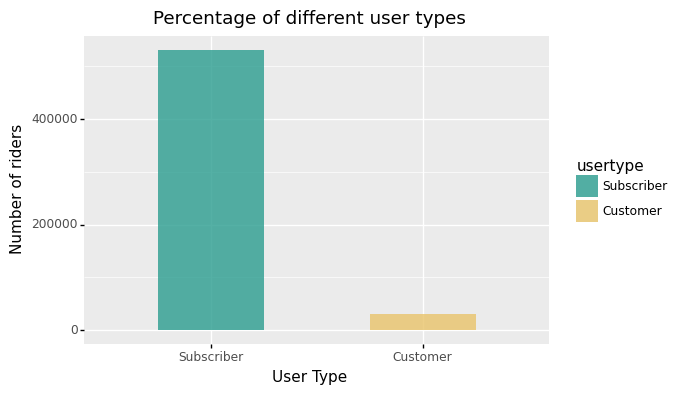

<ggplot: (344875045)>

In [4]:

ggplot_options.figure_size = (6, 4)

usertype_list = bikes_df['usertype'].value_counts().index.tolist()
usertype_cat = pd.Categorical(bikes_df['usertype'], categories=usertype_list)

bikes_df = bikes_df.assign(usertype = usertype_cat)


(ggplot(bikes_df) +
    aes(x='usertype', fill='usertype') +
    geom_bar(stat='count', alpha=0.8, width=0.5) +
    xlab("User Type") +
    ylab("Number of riders") +
    ggtitle("Percentage of different user types") +
    scale_fill_manual(values=["#2a9d8f", "#e9c46a"])
)

From the chart above, we see that most of the bikers are annual subscribers (95%), while only 5% of the users are customers.

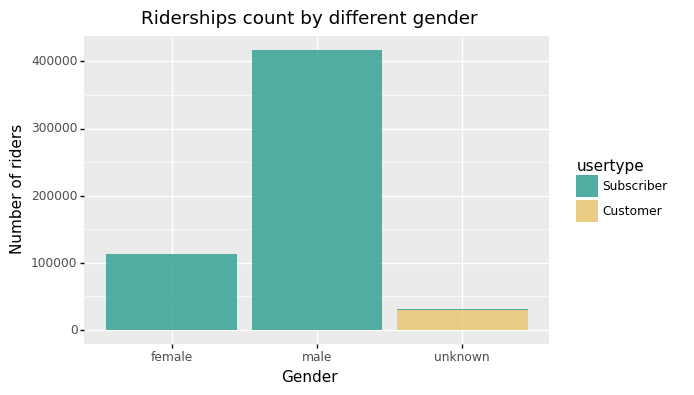

<ggplot: (344929552)>

In [5]:
ggplot_options.figure_size = (6, 4)

(ggplot(bikes_df) +
    aes(x='gender', fill='usertype') +
    geom_bar(stat='count', alpha=0.8) +
    xlab("Gender") +
    ylab("Number of riders") +
    ggtitle("Riderships count by different gender") +
    scale_fill_manual(values=["#2a9d8f", "#e9c46a"])
)

We can see that most of the riders are actually male, and the ones of unknown gender are mostly customers. As we saw in the Initial Data Analysis, the latter might be due to the gender data not being collected for customers.

What about the age of our bikers?

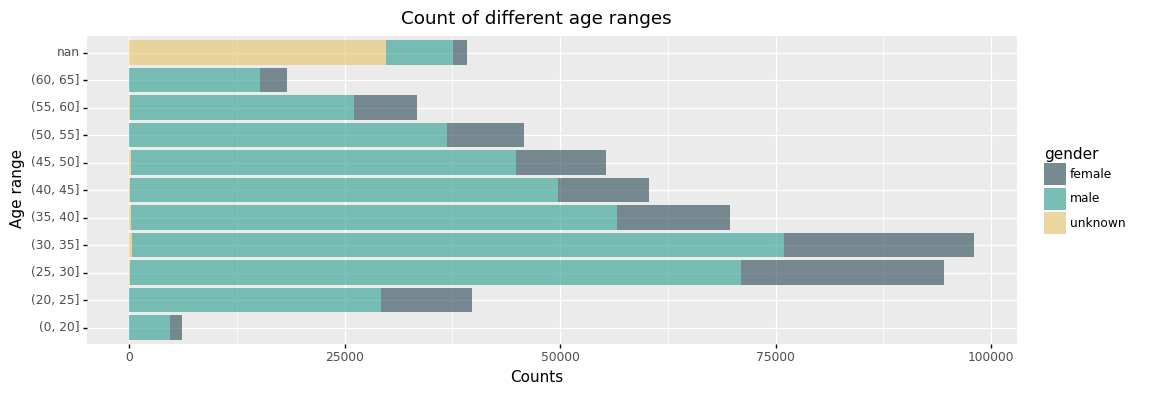

<ggplot: (345033102)>

In [6]:
ggplot_options.figure_size = (12, 4)

AGE_BINS = np.insert(np.arange(start=20, stop=70, step=5), 0, 0, axis=0)

(bikes_df
 .assign(age_range = pd.cut(bikes_df['age'], bins=AGE_BINS).astype(str))
 .pipe(ggplot) +
    aes(x='age_range', fill='gender') +
    geom_bar(stat='count', alpha=0.6) +
    coord_flip() +
    xlab('Age range') +
    ylab('Counts') +
    ggtitle("Count of different age ranges") +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

The largest subgroup of our bikers are between the age of 25 and 35.

**What about the hours our users usually bike at?**

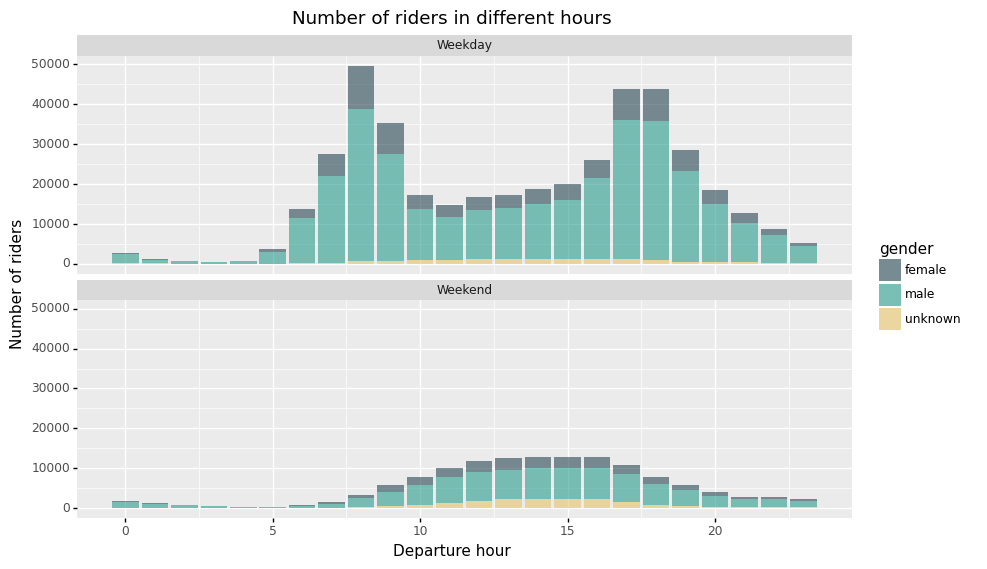

<ggplot: (345034909)>

In [7]:
ggplot_options.figure_size = (10, 6)

(ggplot(bikes_df) +
    aes(x='start_hour', fill='gender') +
    geom_bar(stat='count', alpha=0.6) +
    xlab('Departure hour') +
    ylab("Number of riders") +
    ggtitle("Number of riders in different hours") +
    facet_wrap('day_type', nrow=2) +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

The most active hours in the workweek are from 7 till 8 and after that at 17 till 18 o'clock. The customers are more active in the middle of the day than in the rush hours. Perhaps they are tourists and they are not in a hurry for anywhere.

In the weekend we can see that subscribers are acting the way customers are, they are biking more in the middle of the day than in the rush hours. We have answered how long users ride in different hours, but can we tell how many riders we have in each hour?

### **Median Trip duration for each day**

Lets look in how much are users riding a bike for different days of the week. We are going to use the median as an aggregation statistic, since as we saw, more than 99% of the rides are less than an hour, but we have some rides with trip durations for days.

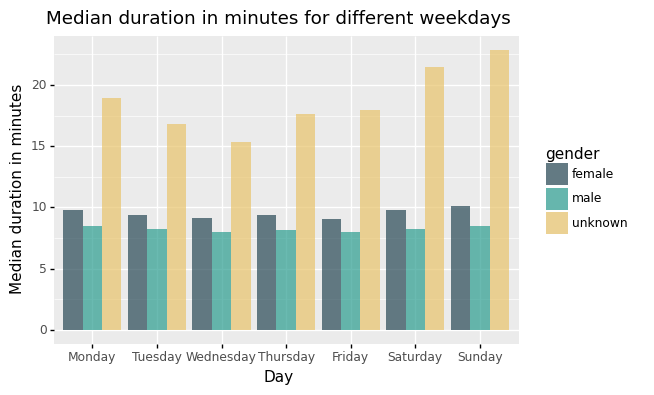

<ggplot: (345170246)>

In [8]:
ggplot_options.figure_size = (6, 4)

(bikes_df
 .groupby(['day_name', 'gender'])
 .median()
 .rename_axis(['weekday', 'gender'], axis='index')
 .reset_index()
 .pipe(ggplot) +
    aes(x='weekday', y='tripduration_minutes', fill='gender') +
    geom_bar(stat='identity', position='dodge', alpha=0.7) +
    xlab('Day') +
    ylab("Median duration in minutes") +
    ggtitle("Median duration in minutes for different weekdays") +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

We can see that the distribution of the subscribers is approximately uniform, as for the customers, they are biking a lot longer in the weekends.

Naturally, we are left with asking how many riders do we have for each day.

### **Average number of riders for each day**

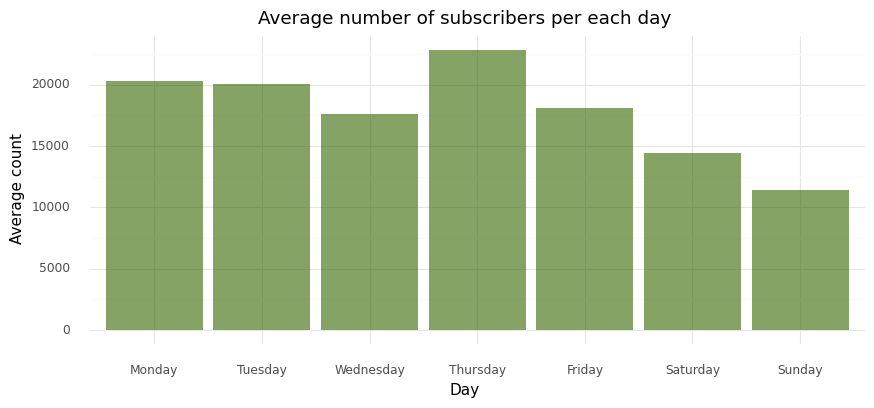

<ggplot: (345213266)>

In [9]:
ggplot_options.figure_size = (10, 4)
(plot_average_rides_count_per_week(bikes_df, 'Subscriber') +
    ggtitle("Average number of subscribers per each day") +
    theme_minimal()
)

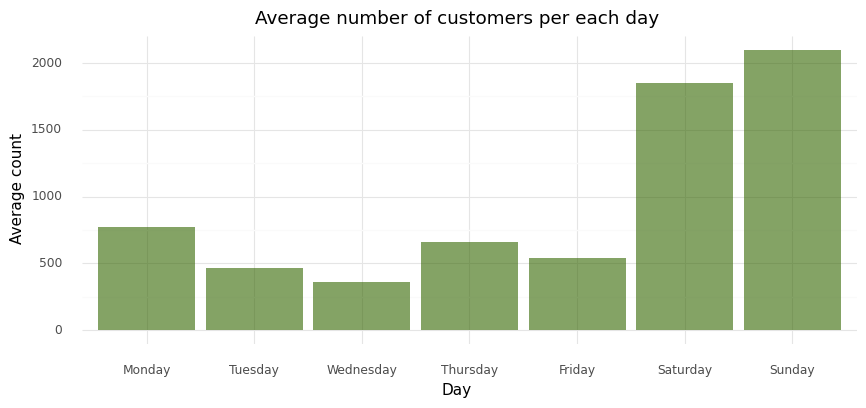

<ggplot: (345212188)>

In [10]:
(plot_average_rides_count_per_week(bikes_df, 'Customer') +
    ggtitle("Average number of customers per each day") +
    theme_minimal()
)

We can see that subscribers are traveling more in the weekdays, while the customers prefer the weekends. This furthers the assumption that customers are using the bikes mostly for fun.


### **Another question we might ask is, who is riding more? Men or women?** 

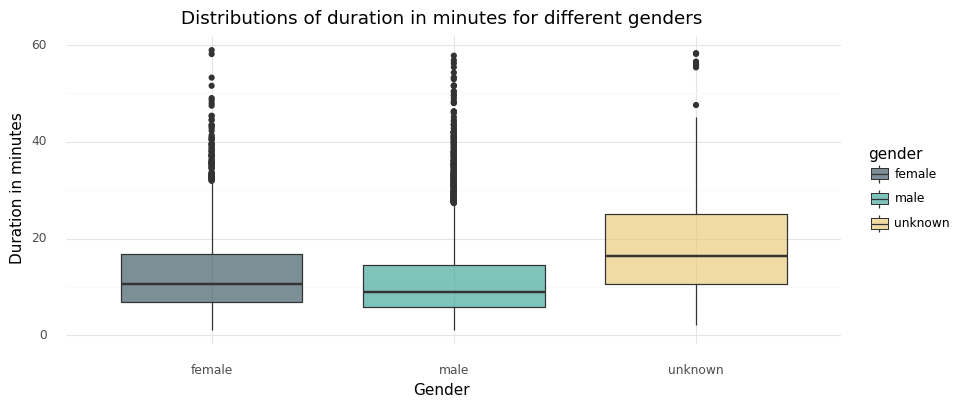

<ggplot: (345214248)>

In [11]:
regular_trips = bikes_df[bikes_df['tripduration_minutes'] < 60]

(ggplot(regular_trips[0:10000]) +
    aes(x='gender', y='tripduration_minutes', fill='gender') +
    geom_boxplot(alpha=0.6) +
    xlab('Gender') +
    ylab("Duration in minutes") +
    ggtitle("Distributions of duration in minutes for different genders") +
    theme_minimal() +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

We see that women are taking a bit more time to arive at a place than men, while the customers are taking the longest. This might be because customers are biking for fun and exploration. Another thing that furthers that assumption is that as we saw in the previous plot, their departure hours are not in the rush hours as it is with the subscribers.